<a href="https://colab.research.google.com/github/Samay-jain622/NEURAL-STYLE-TRANSFER/blob/main/aries_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [ ]:
content_path = tf.keras.utils.get_file(
  'content.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
  'style.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 1s 3us/step


In neural style transfer and similar tasks, the block5_conv1 layer is commonly chosen because it represents higher-level features in the VGG model hierarchy. This layer tends to capture complex patterns and textures in the image, which are often desirable for preserving the content of an image when performing style transfer.

In [ ]:
import cv2
import PIL

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->cd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return gram_matrix / i_j

In [ ]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    vgg.trainable=False
    content_output = vgg.get_layer(content_layers[0]).output
    style_outputs = [vgg.get_layer(style_layer).output for style_layer in style_layers]

    # Compute gram matrices for style outputs
    gram_style_outputs = [gram_matrix(output) for output in style_outputs]

    # Define the model
    model = Model([vgg.input], [content_output] + gram_style_outputs)
    return model

Code to preprocess image and convert it into desired format

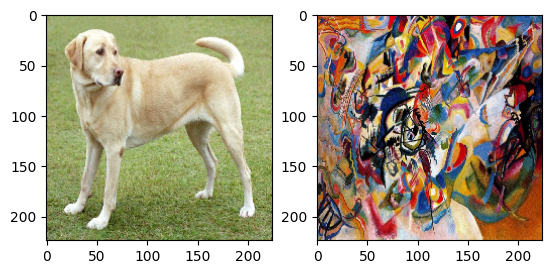

In [ ]:
%matplotlib inline
content_image=cv2.imread(content_path)
content_image=cv2.resize(content_image,(224,224))
#cv2 output image as BGR but vgg is trained on RGB that why we need to convert it into RGB
content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
content_image=tf.image.convert_image_dtype(content_image,tf.float32)
style_image=cv2.imread(style_path)
style_image=cv2.resize(style_image,(224,224))
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
style_image=tf.image.convert_image_dtype(style_image,tf.float32)
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.subplot(1,2,2)
plt.imshow(style_image)

In [ ]:

opt=tf.keras.optimizers.legacy.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)


In [ ]:
def loss_object(style_outputs,content_outputs,style_target,content_style):

  style_weight=1 # style weight represent importance to content in final image we can take it as a hyperparameter and tune it to get desired image
  content_weight=1e-2 # content weight represent importance to content in final image we can take it as a hyperparameter and tune it to get desired image
  content_loss=tf.reduce_mean((content_outputs-content_style)**2)
  style_loss=tf.add_n([tf.reduce_mean((output_-target_)**2) for output_,target_ in zip(style_outputs,style_target)])
  total_loss=content_weight*content_loss+style_weight*style_loss
  return total_loss

we have normalized the image so that

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
vgg_model=load_vgg()
content_image_vgg = preprocess_input(content_image * 255.0)
style_image_vgg = preprocess_input(style_image * 255.0)
content_target=vgg_model(np.array([content_image_vgg]))[0]
style_target=vgg_model(np.array([style_image_vgg]))[1]


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
def train_step(image,epoch):
  with tf.GradientTape() as tape:
    image_vgg=preprocess_input(image*255)
    output=vgg_model(image_vgg)
    loss=loss_object(output[1:],output[0],style_target,content_target)
  gradient=tape.gradient(loss,image)
  opt.apply_gradients([(gradient,image)])
  # as default activation function is relu that's why we need to ensure that pixel value  stays within limits (0-225) hence we use tf.clip
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  if epoch%100 ==0:
    tf.print(f'loss={loss}')


In [ ]:
Epochs=1000
image=tf.image.convert_image_dtype(content_image,tf.float32)
# pixel value are numericals and in backpropogation it will assume pixel value to be constant but we want it to be changed hence we pass image pixel as variable
image=tf.Variable([image])
for i in range(Epochs):
  train_step(image ,i)


NameError: name 'tf' is not defined

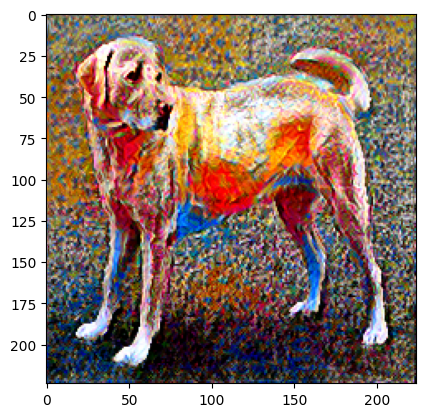

In [ ]:
import PIL
# since we had normalized our image that's why we will rescale it
tensor=image*255
tensor=np.array(tensor,dtype=np.uint8)
# as we know that image is sent as batch in vgg so to ensure that image no does not include batch
if np.ndim(tensor)>3:
  assert tensor.shape[0]==1
  tensor=tensor[0]
tensor_to_rgb = (tensor)
plt.imshow(tensor_to_rgb)
plt.show()

Lets try using Resnet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

In [ ]:
content_path = tf.keras.utils.get_file(
  'content.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
  'style.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->cd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return gram_matrix / i_j

In [ ]:
def load_resnet():
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    content_layers = ['conv4_block6_out']
    style_layers = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    resnet.trainable=False
    content_output = resnet.get_layer(content_layers[0]).output
    style_outputs = [resnet.get_layer(style_layer).output for style_layer in style_layers]

    # Compute gram matrices for style outputs
    gram_style_outputs = [gram_matrix(output) for output in style_outputs]

    # Define the model
    model = Model([resnet.input], [content_output] + gram_style_outputs)
    return model

In [ ]:
%matplotlib inline
content_image=cv2.imread(content_path)
content_image=cv2.resize(content_image,(224,224))

content_image=tf.image.convert_image_dtype(content_image,tf.float32)
style_image=cv2.imread(style_path)
style_image=cv2.resize(style_image,(224,224))
style_image=tf.image.convert_image_dtype(style_image,tf.float32)
plt.subplot(1,2,1)
plt.imshow(content_image)
plt.subplot(1,2,2)
plt.imshow(style_image)

In [ ]:
opt=tf.keras.optimizers.legacy.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)


In [ ]:
def loss_object(style_outputs,content_outputs,style_target,content_style):

  style_weight=10 # style weight represent importance to content in final image we can take it as a hyperparameter and tune it to get desired image
  content_weight=1e-2 # content weight represent importance to content in final image we can take it as a hyperparameter and tune it to get desired image
  content_loss=tf.reduce_mean((content_outputs-content_style)**2)
  style_loss=tf.add_n([tf.reduce_mean((output_-target_)**2) for output_,target_ in zip(style_outputs,style_target)])
  total_loss=content_weight*content_loss+style_weight*style_loss
  return total_loss

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
resnet_model=load_resnet()
content_image_resnet = preprocess_input(content_image * 255.0)
style_image_resnet = preprocess_input(style_image * 255.0)
content_target=resnet_model(np.array([content_image_resnet]))[0]
style_target=resnet_model(np.array([style_image_resnet]))[1]

In [ ]:
def train_step(image,epoch):
  with tf.GradientTape() as tape:
    image_resnet=preprocess_input(image*255)
    output=resnet_model(image_resnet)
    loss=loss_object(output[1:],output[0],style_target,content_target)
  gradient=tape.gradient(loss,image)
  opt.apply_gradients([(gradient,image)])
  # as default activation function is relu that's why we need to ensure that pixel value  stays within limits (0-225) hence we use tf.clip
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  if epoch%100 ==0:
    tf.print(f'loss={loss}')

In [ ]:
Epochs=1000
image=tf.image.convert_image_dtype(content_image,tf.float32)
# pixel value are numericals and in backpropogation it will assume pixel value to be constant but we want it to be changed hence we pass image pixel as variable
image=tf.Variable([image])
for i in range(Epochs):
  train_step(image ,i)

In [ ]:
import PIL
# since we had normalized our image that's why we will rescale it
tensor=image*255
tensor=np.array(tensor,dtype=np.uint8)
# as we know that image is sent as batch in resnet so to ensure that image no does not include batch
if np.ndim(tensor)>3:
  assert tensor.shape[0]==1
  tensor=tensor[0]
  #resnet gives image_as bgr but we want it in rgb hence we convert it to rgb
tensor_to_rgb = cv2.cvtColor(tensor, cv2.COLOR_BGR2RGB)
plt.imshow(tensor_to_rgb)
plt.show()